<a href="https://colab.research.google.com/github/bastiloeblein/ProbML_HW/blob/main/Play_around_with_Activation_Functions_and_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propagating Gradients Backwards
---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Propagating-Gradients-Backwards" data-toc-modified-id="Propagating-Gradients-Backwards-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Propagating Gradients Backwards</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Unit-Tests" data-toc-modified-id="Unit-Tests-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Unit Tests</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Normalize-Data" data-toc-modified-id="Normalize-Data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Normalize Data</a></span></li></ul></li><li><span><a href="#Backpropagation-from-scratch" data-toc-modified-id="Backpropagation-from-scratch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Backpropagation from scratch</a></span><ul class="toc-item"><li><span><a href="#Linear-Layer" data-toc-modified-id="Linear-Layer-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Linear Layer</a></span></li><li><span><a href="#Activation-Layer" data-toc-modified-id="Activation-Layer-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Activation Layer</a></span></li><li><span><a href="#Loss-Layer" data-toc-modified-id="Loss-Layer-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Loss Layer</a></span></li><li><span><a href="#Feedforward-Network" data-toc-modified-id="Feedforward-Network-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Feedforward Network</a></span></li></ul></li><li><span><a href="#Refactor-&amp;-Redesign" data-toc-modified-id="Refactor-&amp;-Redesign-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Refactor &amp; Redesign</a></span><ul class="toc-item"><li><span><a href="#Abstract-Layer-Class" data-toc-modified-id="Abstract-Layer-Class-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Abstract Layer Class</a></span></li><li><span><a href="#Linear-Layer" data-toc-modified-id="Linear-Layer-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Linear Layer</a></span></li><li><span><a href="#Activation-Layer" data-toc-modified-id="Activation-Layer-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Activation Layer</a></span></li><li><span><a href="#Loss-Layer" data-toc-modified-id="Loss-Layer-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Loss Layer</a></span></li><li><span><a href="#Feedforward-Network" data-toc-modified-id="Feedforward-Network-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Feedforward Network</a></span></li></ul></li><li><span><a href="#Comparison-with-PyTorch's-Autograd" data-toc-modified-id="Comparison-with-PyTorch's-Autograd-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparison with PyTorch's Autograd</a></span><ul class="toc-item"><li><span><a href="#PyTorch's-Performance" data-toc-modified-id="PyTorch's-Performance-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>PyTorch's Performance</a></span></li><li><span><a href="#Our-Model's-Performance" data-toc-modified-id="Our-Model's-Performance-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Our Model's Performance</a></span></li></ul></li></ul></div>

## Import Libraries

In [ ]:
import math
import operator

import torch
from torchvision.datasets import MNIST

import time

import matplotlib.pyplot as plt
%matplotlib inline

## Unit Tests

In [ ]:
def test(a, b, compare, compare_name=None):
    if compare_name is None:
        compare_name = compare.__name__
    assert compare(a, b),\
    f"{compare_name} check failed:\n{a}\n{b}"

def test_zero(x, tol=1e-3):
    test(x, tol, operator.le, f"Zero (less than tolerance: {tol})")

def test_equality(a, b):
    test(a, b, operator.eq, "Equality")

def test_approximately(a, b):
    allclose = partial(torch.allclose, atol=1e-5, rtol=1e-03)
    if not isinstance(a, torch.Tensor) or not isinstance(b, torch.Tensor):
        a = torch.tensor(a)
        b = torch.tensor(b)
    test(a, b, allclose, "Approximate Equality")

## Load Data

In [ ]:
dataset = MNIST(root="../data/", download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 107414957.60it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40868992.52it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 38669317.33it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11088782.75it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
x, y = dataset.data.float(), dataset.targets
x_train, x_test = x[:50000], x[50000:]
y_train, y_test = y[:50000], y[50000:]

x_train.shape, x_test.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

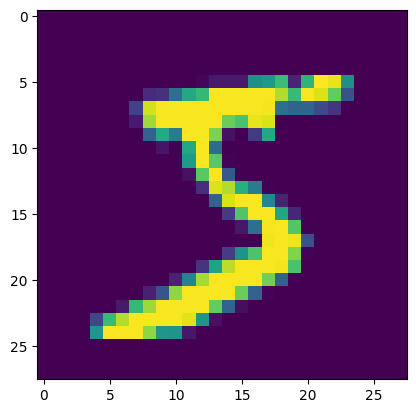

In [ ]:
plt.imshow(x_train[0])

**Flatten**

In [ ]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

In [ ]:
n, m = x_train.shape
c = (y_train.max() - y_train.min()).item()
n, m, c

(50000, 784, 9)

## Normalize Data

In [ ]:
def normalize(x, mean, std): return (x-mean)/std

In [ ]:
train_mean = x_train.mean()
train_std = x_train.std()

In [ ]:
x_train = normalize(x_train, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std)

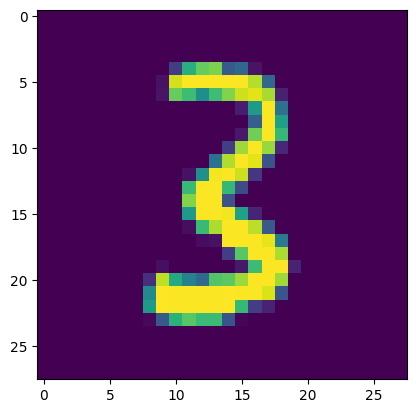

In [ ]:
plt.imshow(x_test[0].view(28,28))

# Backpropagation from scratch

## Linear Layer

In [ ]:
class Linear():
    '''Affine layer with weight and bias initialized using Kaiming initialization'''
    def __init__(self, in_size, out_size):
        self.weight = torch.randn(in_size, out_size) * math.sqrt(2/in_size)
        self.bias = torch.zeros(out_size)

    def __repr__(self):
        return f"(Linear: in={self.weight.shape[0]} out={self.weight.shape[1]})"

    def forward(self, x):
        self.x = x
        self.y = self.x@self.weight + self.bias
        return self.y

    def backward(self):
        self.weight.g = self.x.t() @ self.y.g
        self.bias.g = self.y.g
        self.x.g = self.y.g @ self.weight.t()

## Activation Layer

In [ ]:
class ReLU():
    '''Rectified Linear Unit Layer'''

    def __init__(self, shift=0.):
        self.shift = shift

    def __repr__(self):
        return f"(ReLU: shift={self.shift})"

    def forward(self, x):
        self.x = x
        self.y = self.x.clamp_min(0.) - self.shift
        return self.y

    def backward(self):
        self.x.g = self.y.g * (self.x>0).float()

## Loss Layer

In [ ]:
class MSE():
    '''Mean Squared Error Layer'''

    def __repr__(self):
        return "Loss: Mean Squared Error"

    def forward(self, y_pred, y_true):
        self.x1 = y_pred
        self.x2 = y_true
        self.y = (self.x1-self.x2).pow(2).mean()
        return self.y

    def backward(self):
        self.x1.g = 2 * (self.x1-self.x2) / self.x1.shape[0]

## Feedforward Network

In [ ]:
class FeedForwardNN():
    '''Feedforward neural network'''

    def __init__(self, x_dim, y_dim, n_layers):
        # get an exponentially spaced array of layer dimensions
        def _exp(pos): return math.ceil(x_dim * (y_dim/x_dim)**pos)
        layer_dims  = [_exp(pos/n_layers) for pos in range(0, n_layers+1)]
        # construct the list of layers
        self.layers = []
        for i in range(n_layers):
            in_dim, out_dim = layer_dims[i], layer_dims[i+1]
            self.layers.append(Linear(in_dim, out_dim))
            self.layers.append(ReLU())
        self.loss = MSE()

    def __repr__(self):
        model_str = "\n".join(l.__repr__() for l in self.layers)
        model_str += "\n" + self.loss.__repr__()
        return model_str

    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x

    def backward(self):
        self.loss.backward()
        for layer in reversed(self.layers):
            layer.backward()

In [ ]:
model = FeedForwardNN(x_dim=784, y_dim=1, n_layers=5)
model

(Linear: in=784 out=207)
(ReLU: shift=0.0)
(Linear: in=207 out=55)
(ReLU: shift=0.0)
(Linear: in=55 out=15)
(ReLU: shift=0.0)
(Linear: in=15 out=4)
(ReLU: shift=0.0)
(Linear: in=4 out=1)
(ReLU: shift=0.0)
Loss: Mean Squared Error

In [ ]:
y_pred = model.forward(x_train)
loss = model.loss.forward(y_pred.float(), y_train.unsqueeze(-1).float())
model.backward()

# Refactor & Redesign

## Abstract Layer Class

In [ ]:
class Layer():
    '''Abstract Layer class like PyTorch's nn.Module'''

    def __call__(self, *args):
        self.args = args
        self.y = self.forward(*self.args)
        return self.y

    def __repr__(self):
        raise NotImplementedError("__repr__ method not implemented")

    def forward(self, *args):
        raise NotImplementedError("forward method not implemented")

    def backward(self):
        raise NotImplementedError("backward method not implemented")

## Linear Layer

In [ ]:
class Linear(Layer):
    '''Affine layer with weight and bias initialized using Kaiming initialization'''
    def __init__(self, in_size, out_size):
        self.weight = torch.randn(in_size, out_size) * math.sqrt(2/in_size)
        self.bias = torch.zeros(out_size)

    def __repr__(self):
        return f"(Linear: in={self.weight.shape[0]} out={self.weight.shape[1]})"

    def forward(self, x):
        return x@self.weight + self.bias

    def backward(self):
        self.weight.g = self.args[0].t() @ self.y.g
        self.bias.g = self.y.g
        self.args[0].g = self.y.g @ self.weight.t()

## Activation Layer

In [ ]:
class ReLU(Layer):
    '''Rectified Linear Unit Layer'''

    def __init__(self, shift=0.):
        self.shift = shift

    def __repr__(self):
        return f"(ReLU: shift={self.shift})"

    def forward(self, x):
        return x.clamp_min(0.) - self.shift

    def backward(self):
        self.args[0].g = self.y.g * (self.args[0]>0).float()

## Loss Layer

In [ ]:
class MSE(Layer):
    '''Mean Squared Error Layer'''

    def __repr__(self):
        return "Loss: Mean Squared Error"

    def forward(self, y_pred, y_true):
        return (y_pred-y_true).pow(2).mean()

    def backward(self):
        n = self.args[0].shape[0]
        self.args[0].g = 2 * (self.args[0] - self.args[1]) / n

## Feedforward Network

In [ ]:
class FeedForwardNN(Layer):
    '''Feedforward neural network'''

    def __init__(self, x_dim, y_dim, n_layers):
        # get an exponentially spaced array of layer dimensions
        def _exp(pos): return math.ceil(x_dim * (y_dim/x_dim)**pos)
        layer_dims  = [_exp(pos/n_layers) for pos in range(0, n_layers+1)]
        # construct the list of layers
        self.layers = []
        for i in range(n_layers):
            in_dim, out_dim = layer_dims[i], layer_dims[i+1]
            self.layers.append(Linear(in_dim, out_dim))
            self.layers.append(ReLU())
        self.loss = MSE()

    def __repr__(self):
        model_str = "\n".join(l.__repr__() for l in self.layers)
        model_str += "\n" + self.loss.__repr__()
        return model_str

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self):
        self.loss.backward()
        for layer in reversed(self.layers):
            layer.backward()

In [ ]:
model = FeedForwardNN(x_dim=784, y_dim=1, n_layers=5)
model

(Linear: in=784 out=207)
(ReLU: shift=0.0)
(Linear: in=207 out=55)
(ReLU: shift=0.0)
(Linear: in=55 out=15)
(ReLU: shift=0.0)
(Linear: in=15 out=4)
(ReLU: shift=0.0)
(Linear: in=4 out=1)
(ReLU: shift=0.0)
Loss: Mean Squared Error

In [ ]:
y_pred = model(x_train)
loss = model.loss(y_pred.float(), y_train.unsqueeze(-1).float())
model.backward()

# Comparison with PyTorch's Autograd

In [ ]:
import timeit
from functools import partial
from torch import nn

In [ ]:
torch.manual_seed(42)

## PyTorch's Performance

In [ ]:
class TorchModel(nn.Module):

    def __init__(self, x_dim, h_dim, y_dim):
        super().__init__()
        self.layers = [nn.Linear(x_dim, h_dim),
                       nn.ReLU(),
                       nn.Linear(h_dim,y_dim)]
        self.loss = nn.MSELoss()

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [ ]:
torch_model = TorchModel(784, 400, 1)

In [ ]:
torch_forward = timeit.timeit(partial(torch_model,x_train), number=10)
y_pred = torch_model(x_train)
loss = torch_model.loss(y_pred, y_train.unsqueeze(-1).float())
torch_backward = timeit.timeit(loss.backward, number=1)

In [ ]:
torch_forward, torch_backward

(5.882515522999995, 1.1950620910000112)

## Our Model's Performance

In [ ]:
class OurModel(Layer):

    def __init__(self, x_dim, h_dim, y_dim):
        self.layers = [Linear(x_dim, h_dim),
                       ReLU(),
                       Linear(h_dim, y_dim)]
        self.loss = MSE()

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def backward(self):
        self.loss.backward()
        for layer in reversed(self.layers):
            layer.backward()

In [ ]:
model = OurModel(784, 400, 1)

## Play around with Layers and Activation functions

### Create function to calculate accuracy

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [126]:
def create_train_dataloader(x_train, y_train, batch_size):
    # Convert the training data to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    # Create a TensorDataset from the input tensors
    dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # Create a DataLoader to handle batching and shuffling
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

In [127]:
train_dataloader = create_train_dataloader(x_train, y_train, 32)
test_dataloader = create_train_dataloader(x_test, y_test, 32)

<ipython-input-126-4a0656b67a63>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
<ipython-input-126-4a0656b67a63>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


In [135]:
import torch
import torch.nn as nn
import time

def train_and_get_acc(net, train_dataloader, test_dataloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    # Training loop
    start_time = time.time()
    for epoch in range(10):
        epoch_start_time = time.time()
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            start_forward = time.time()
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch + 1} Time: {epoch_time:.2f} seconds")

    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time:.2f} seconds")

    # Evaluation
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    return accuracy

#### Create new Class, for different activation functions

In [129]:
class MyNet(nn.Module):
    def __init__(self, layers):
        super(MyNet, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.loss = nn.MSELoss()

    def forward(self, x):
      for l in self.layers:
            x = l(x)
      return x

#### Take dims from above

In [130]:
x_dim = 784
h_dim = 400
y_dim = 10
n = 10

### ReLU Activation

#### 2 Layers

In [136]:
layers2 = [
    nn.Linear(x_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim,y_dim)
]

torch_model = MyNet(layers2)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)


Epoch 1 Time: 2.88 seconds
Epoch 2 Time: 2.88 seconds
Epoch 3 Time: 3.11 seconds
Epoch 4 Time: 4.72 seconds
Epoch 5 Time: 3.27 seconds
Epoch 6 Time: 3.03 seconds
Epoch 7 Time: 9.18 seconds
Epoch 8 Time: 4.47 seconds
Epoch 9 Time: 3.17 seconds
Epoch 10 Time: 3.88 seconds
Total Training Time: 40.60 seconds
Test Accuracy: 0.9733


#### 3 Layers

In [137]:
layers3 = [
    nn.Linear(x_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim,y_dim)
]


torch_model = MyNet(layers3)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

Epoch 1 Time: 4.33 seconds
Epoch 2 Time: 7.70 seconds
Epoch 3 Time: 5.89 seconds
Epoch 4 Time: 5.62 seconds
Epoch 5 Time: 4.20 seconds
Epoch 6 Time: 4.58 seconds
Epoch 7 Time: 5.24 seconds
Epoch 8 Time: 4.25 seconds
Epoch 9 Time: 9.14 seconds
Epoch 10 Time: 4.25 seconds
Total Training Time: 55.19 seconds
Test Accuracy: 0.9764


#### 5 Layers

In [138]:
layers5 = [
    nn.Linear(x_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, y_dim),
]

torch_model = MyNet(layers5)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

Epoch 1 Time: 8.73 seconds
Epoch 2 Time: 7.25 seconds
Epoch 3 Time: 12.03 seconds
Epoch 4 Time: 8.68 seconds
Epoch 5 Time: 6.94 seconds
Epoch 6 Time: 8.49 seconds
Epoch 7 Time: 7.70 seconds
Epoch 8 Time: 7.48 seconds
Epoch 9 Time: 8.45 seconds
Epoch 10 Time: 7.02 seconds
Total Training Time: 82.78 seconds
Test Accuracy: 0.9773


### Sigmoid Activation Function

#### 2 Layer

In [139]:
layers2 = [
    nn.Linear(x_dim, h_dim),
    nn.Sigmoid(),
    nn.Linear(h_dim,y_dim)
]

torch_model = MyNet(layers2)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

Epoch 1 Time: 4.01 seconds
Epoch 2 Time: 3.03 seconds
Epoch 3 Time: 2.90 seconds
Epoch 4 Time: 2.79 seconds
Epoch 5 Time: 3.34 seconds
Epoch 6 Time: 3.53 seconds
Epoch 7 Time: 2.91 seconds
Epoch 8 Time: 2.82 seconds
Epoch 9 Time: 3.02 seconds
Epoch 10 Time: 4.02 seconds
Total Training Time: 32.37 seconds
Test Accuracy: 0.9305


#### 3 Layers

In [140]:
layers3 = [
    nn.Linear(x_dim, h_dim),
    nn.Sigmoid(),
    nn.Linear(h_dim,h_dim),
    nn.Sigmoid(),
    nn.Linear(h_dim,y_dim)
]

torch_model = MyNet(layers3)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

Epoch 1 Time: 4.29 seconds
Epoch 2 Time: 4.26 seconds
Epoch 3 Time: 5.59 seconds
Epoch 4 Time: 4.18 seconds
Epoch 5 Time: 4.27 seconds
Epoch 6 Time: 4.96 seconds
Epoch 7 Time: 4.01 seconds
Epoch 8 Time: 4.78 seconds
Epoch 9 Time: 4.64 seconds
Epoch 10 Time: 4.03 seconds
Total Training Time: 45.02 seconds
Test Accuracy: 0.9174


##### 5 Layers

In [ ]:
layers5 = [
    nn.Linear(x_dim, h_dim),
    nn.Sigmoid(),
    nn.Linear(h_dim, h_dim),
    nn.Sigmoid(),
    nn.Linear(h_dim, h_dim),
    nn.Sigmoid(),
    nn.Linear(h_dim, h_dim),
    nn.Sigmoid(),
    nn.Linear(h_dim, y_dim),
]

torch_model = MyNet(layers5)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

Epoch 1 Time: 8.00 seconds
Epoch 2 Time: 7.38 seconds
Epoch 3 Time: 8.12 seconds
Epoch 4 Time: 8.52 seconds
Epoch 5 Time: 7.29 seconds
Epoch 6 Time: 8.88 seconds


### ELU

####  2 Layers

In [ ]:
layers2 = [
    nn.Linear(x_dim, h_dim),
    nn.ELU(),
    nn.Linear(h_dim,y_dim)
]

torch_model = MyNet(layers2)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

#### 3 Layers

In [ ]:
layers3 = [
    nn.Linear(x_dim, h_dim),
    nn.ELU(),
    nn.Linear(h_dim,h_dim),
    nn.ELU(),
    nn.Linear(h_dim,y_dim)
]

torch_model = MyNet(layers3)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

#### 5 Layers

In [ ]:
layers5 = [
    nn.Linear(x_dim, h_dim),
    nn.ELU(),
    nn.Linear(h_dim, h_dim),
    nn.ELU(),
    nn.Linear(h_dim, h_dim),
    nn.ELU(),
    nn.Linear(h_dim, h_dim),
    nn.ELU(),
    nn.Linear(h_dim, y_dim),
]

torch_model = MyNet(layers5)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

### Combination

In [ ]:
layers3 = [
    nn.Linear(x_dim, h_dim),
    nn.Sigmoid(),
    nn.Linear(h_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, y_dim),
]

torch_model = MyNet(layers3)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

In [ ]:
layers5 = [
    nn.Linear(x_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, h_dim),
    nn.Tanh(),
    nn.Linear(h_dim, h_dim),
    nn.LeakyReLU(),
    nn.Linear(h_dim, y_dim)
]

torch_model = MyNet(layers5)
acc = train_and_get_acc(torch_model, train_dataloader, test_dataloader)

___